### Vary number of hidden layers between 1 and 3 , and the number of hidden units per layer between 50 and 250 (in steps of 50).
(Use the same number of units per layer.)

In [1]:
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
# import dataset 
data = np.loadtxt(open('mnist_train_small.csv', 'rb'), delimiter=',')
# extract labels (number ID's) and remove from data
labels = data[:,0]
data = data[:,1:]

dataNorm = data / np.max(data)


In [3]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data,test_data,train_labels, test_labels= train_test_split(dataT, labelsT,test_size=0.1)
 
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
 
batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [10]:
def createTheMNISTNet(nLayers,nUnits):
    
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            # self.input = nn.Linear(784,64)
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers
            self.nUnits = nUnits
            self.layers['input'] = nn.Linear(784, nUnits)
            ### hidden layer
            for i in range(nLayers):
                self.layers['layer{}'.format(i)] = nn.Linear(nUnits, nUnits)
            
            # self.fc1 = nn.Linear(64,32)
            # self.fc2 = nn.Linear(32,32)
            self.layers['output'] = nn.Linear(nUnits, 10)
            # self.output =  nn.Linear(32,10)
            
        def forward(self, x):
            
            x = F.relu(self.layers['input'](x))
            
            for i in range(self.nLayers):
                x = F.relu(self.layers['layer{}'.format(i)](x))
            
            return torch.log_softmax(self.layers['output'](x),dim=1)
            
    net = Net()
    
    lossFn = nn.NLLLoss()
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    return net,lossFn,optimizer

In [9]:
def funcToTrainModel(nLayers,nUnits):
    
    num_epochs = 60
    
    net,lossFn,optimizer = createTheMNISTNet(nLayers,nUnits)
    
    losses = torch.zeros(num_epochs)
    trainAcc = []
    testAcc = []
    
    for epochI in range(num_epochs):
        
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            yHat = net(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            # compute acc
            matches = torch.argmax(yHat,dim=1) == y
            matchesNumeric = matches.float()
            accPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accPct)
            
        trainAcc.append( np.mean(batchAcc) )
        
        losses[epochI] = np.mean(batchLoss)
        
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        
        
        testAcc.append( 100*torch.mean((torch.argmax(yHat,dim=1) == y).float()) )
        
    
    return trainAcc,testAcc,losses,net

In [11]:
# experiment parameters
numLayers = range(1,4)
numUnits = np.arange(50,251,50)

# init result matrices
accs = np.zeros((2,len(numUnits),len(numLayers)))

for unitIdx in range(len(numUnits)):
    for layerIdx in range(len(numLayers)):
       
       #  includes creating fresh net each time
       trainAcc,testAcc,losses,net = funcToTrainModel(numLayers[layerIdx],numUnits[unitIdx])
       
       accs[0,unitIdx,layerIdx] = np.mean(testAcc[-5:])
       accs[1,unitIdx,layerIdx] = np.mean(trainAcc[-5:])
       

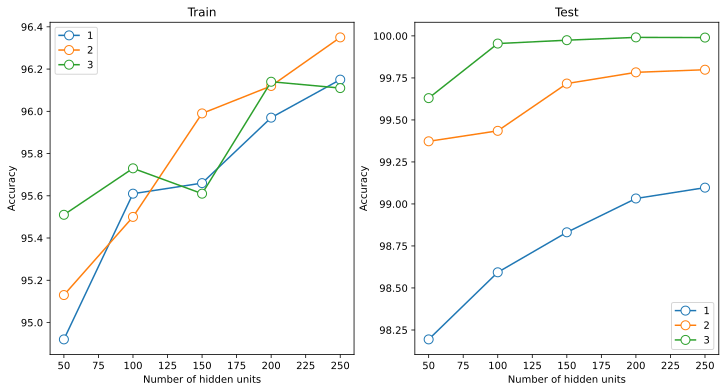

In [12]:
fix,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(numUnits,accs[0,:,:],'o-',markerfacecolor="w",markersize=9)
ax[1].plot(numUnits,accs[1,:,:],'o-',markerfacecolor="w",markersize=9)

for i in range(2):
    ax[i].legend(numLayers)
    ax[i].set_xlabel("Number of hidden units")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_title(["Train" if i == 0 else "Test"][0])

plt.show()